<a href="https://colab.research.google.com/github/NeuralNetGeek/monkeypox-diagnosis/blob/main/Monkey%20Pox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.model_selection import GridSearchCV
import shap
from shap import TreeExplainer, KernelExplainer, summary_plot
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', module='sklearn.exceptions')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

DATA COLLECTION

The dataset was sourced from https://www.kaggle.com/datasets/muhammad4hmed/monkeypox-patients-dataset

DATA CLEANING, EXPLORATION AND PREPROCESSING

In [77]:
cols = ['Patient_ID', 'Systemic Illness', 'Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection', 'MonkeyPox']
df = pd.read_csv('monkey.data.csv')
df.columns = cols
df.drop(['Patient_ID', 'Systemic Illness'], axis=1, inplace=True)

features = ['Rectal Pain', 'Penile Oedema', 'Oral Lesions', 'Sore Throat', 'Swollen Tonsils', 'Solitary Lesion', 'HIV Infection',  'Sexually Transmitted Infection']
df[features] = df[features].astype(int)

df['Monkey Pox'] = df['MonkeyPox'].map({'Positive': 1, 'Negative': 0})
df = df.drop(['MonkeyPox'], axis=1)

df.head()

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,Monkey Pox
0,0,1,1,1,0,1,0,0,0
1,1,0,1,1,0,0,1,0,1
2,0,1,1,0,0,0,1,0,1
3,1,0,0,0,1,1,1,0,1
4,1,1,1,0,0,1,1,0,1


In [78]:
df['Monkey Pox'].value_counts()

,count
Monkey Pox,
1,15909
0,9091


In [79]:
features_encoded = ['Rectal Pain', 'Penile Oedema', 'Oral Lesions', 'Sore Throat', 'Swollen Tonsils', 'Solitary Lesion', 'HIV Infection',  'Sexually Transmitted Infection']
target = 'Monkey Pox'


X = df[features_encoded]
y = df[target]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

smote = SMOTE(k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

TRAIN, VALID AND TEST

In [80]:
def evaluate_classifiers(models, X_scaled, y, show_reports=True, show_confusion=True):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    summary = []

    for name, model in models.items():
        try:
            cv_scores = cross_validate(model, X_scaled, y, cv=skf, scoring='f1')
            mean_cv_score = cv_scores['test_score'].mean()

            model.fit(X_scaled, y)
            y_pred = model.predict(X_scaled)

            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred, zero_division=0)
            rec = recall_score(y, y_pred, zero_division=0)
            f1 = f1_score(y, y_pred, zero_division=0)

            roc_auc = np.nan
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_scaled)[:, 1]
                if len(np.unique(y)) > 1:
                    roc_auc = roc_auc_score(y, y_prob)
                else:
                    roc_auc = np.nan


            summary.append({
                'Model': name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC-AUC': roc_auc,
                'Cross-Validation F1 Mean': mean_cv_score
            })

            if show_reports:
                print(f"\nModel: {name}")
                print(f"Cross-Validation F1 Mean: {mean_cv_score:.4f}")
                if show_confusion:
                  print("Confusion Matrix:")
                  print(confusion_matrix(y, y_pred))
                  print("\nClassification Report:")
                  print(classification_report(y, y_pred, zero_division=0))

        except Exception as e:
            print(f"\nError with {name}: {e}")
            summary.append({
                'Model': name,
                'Accuracy': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'F1 Score': np.nan,
                'ROC-AUC': np.nan,
                'Cross-Validation F1 Mean': np.nan
            })


    return pd.DataFrame(summary)

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear', max_iter=100),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(C=0.1, kernel='rbf', gamma='scale', class_weight='balanced', probability=True),
    "Random Forest": RandomForestClassifier(bootstrap=True, class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=42),
    "Gradient Boosting": HistGradientBoostingClassifier(random_state=42)
}


results = evaluate_classifiers(models, X_train_scaled, y_train_smote)
print("\nModel Performance Summary:")
print(results)


Model: Logistic Regression
Cross-Validation F1 Mean: 0.6108
Confusion Matrix:
[[5407 3502]
 [3439 5470]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      8909
           1       0.61      0.61      0.61      8909

    accuracy                           0.61     17818
   macro avg       0.61      0.61      0.61     17818
weighted avg       0.61      0.61      0.61     17818


Model: K-Nearest Neighbors
Cross-Validation F1 Mean: 0.6231
Confusion Matrix:
[[3229 5680]
 [2217 6692]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.36      0.45      8909
           1       0.54      0.75      0.63      8909

    accuracy                           0.56     17818
   macro avg       0.57      0.56      0.54     17818
weighted avg       0.57      0.56      0.54     17818


Model: Naive Bayes
Cross-Validation F1 Mean: 0.6097
Confusion Matrix:
[[5486 3423]
 [

In [81]:
def evaluate_model(model, X_valid_scaled, y_valid, show_confusion=True):
    y_pred = model.predict(X_valid_scaled)

    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred, zero_division=0)
    rec = recall_score(y_valid, y_pred, zero_division=0)
    f1 = f1_score(y_valid, y_pred, zero_division=0)

    y_prob = None
    roc_auc = 0.0
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_valid_scaled)[:, 1]
        if len(np.unique(y_valid)) > 1:
            roc_auc = roc_auc_score(y_valid, y_prob)

    if show_confusion:
        print("Confusion Matrix:")
        print(confusion_matrix(y_valid, y_pred))
        print("Class Distribution:", dict(pd.Series(y_valid).value_counts()))

    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }


lr_valid_results = evaluate_model(models['Logistic Regression'], X_valid_scaled, y_valid)
svm_valid_results = evaluate_model(models['Support Vector Machine'], X_valid_scaled, y_valid)
nb_valid_results = evaluate_model(models['Naive Bayes'], X_valid_scaled, y_valid)
rf_valid_results = evaluate_model(models['Random Forest'], X_valid, y_valid)
gb_valid_results = evaluate_model(models['Gradient Boosting'], X_valid, y_valid)

comparison_df = pd.DataFrame({
    "Logistic Regression": lr_valid_results,
    "Support Vector Machine": svm_valid_results,
    "Naive Bayes": nb_valid_results,
    "Random Forest": rf_valid_results,
    "Gradient Boosting": gb_valid_results
})
comparison_df = comparison_df.T

print("\nValidation Set Performance Comparison:")
print(comparison_df.round(4))

Confusion Matrix:
[[1315  867]
 [1485 2333]]
Class Distribution: {1: np.int64(3818), 0: np.int64(2182)}
Confusion Matrix:
[[1236  946]
 [1391 2427]]
Class Distribution: {1: np.int64(3818), 0: np.int64(2182)}
Confusion Matrix:
[[1331  851]
 [1526 2292]]
Class Distribution: {1: np.int64(3818), 0: np.int64(2182)}
Confusion Matrix:
[[1246  936]
 [1423 2395]]
Class Distribution: {1: np.int64(3818), 0: np.int64(2182)}
Confusion Matrix:
[[1137 1045]
 [1233 2585]]
Class Distribution: {1: np.int64(3818), 0: np.int64(2182)}

Validation Set Performance Comparison:
                        Accuracy  Precision  Recall  F1 Score  ROC-AUC
Logistic Regression       0.6080     0.7291  0.6111    0.6649   0.6465
Support Vector Machine    0.6105     0.7195  0.6357    0.6750   0.6317
Naive Bayes               0.6038     0.7292  0.6003    0.6585   0.6467
Random Forest             0.6068     0.7190  0.6273    0.6700   0.6312
Gradient Boosting         0.6203     0.7121  0.6771    0.6941   0.6354


In [82]:
model_best = {"Gradient Boosting": models["Gradient Boosting"]}

def find_best_balanced_threshold(y_true, y_proba):
    best_threshold = 0.5
    best_score = -1
    best_cm = None

    thresholds = np.arange(0.01, 0.99, 0.01)
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        score = tp + tn
        if score > best_score:
            best_score = score
            best_threshold = t
            best_cm = (tn, fp, fn, tp)
    return best_threshold, best_cm

def evaluate_final(y_true, y_pred, y_proba, model_name, threshold):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)

    print(f"\n=== Final Balanced Test Evaluation: {model_name} ===")
    print(f"Threshold Chosen (from Validation Set): {threshold:.2f}")
    print(f"Confusion Matrix (on Test Set): TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    return threshold

In [83]:
tuned_thresholds = {}

for model_name, model in model_best.items():
    if hasattr(model, "predict_proba"):
        y_proba_valid = model.predict_proba(X_valid_scaled)[:, 1]
    else:
        y_proba_valid = model.decision_function(X_valid_scaled)

    best_thresh_valid, _ = find_best_balanced_threshold(y_valid, y_proba_valid)

    tuned_thresholds[model_name] = best_thresh_valid
    print(f"{model_name}: Best Balanced Threshold (Validation Set) = {best_thresh_valid:.2f}")

print("\nTuned Thresholds (from Validation Set):")
print(tuned_thresholds)

Gradient Boosting: Best Balanced Threshold (Validation Set) = 0.32

Tuned Thresholds (from Validation Set):
{'Gradient Boosting': np.float64(0.32)}


In [84]:
if 'tuned_thresholds' not in locals():
    print("Error: tuned_thresholds not found. Please run the previous cell first.")
else:
    for model_name, model in model_best.items():
        y_proba_test = model.predict_proba(X_test_scaled)[:, 1]
        best_thresh_from_valid = tuned_thresholds.get(model_name, 0.5)
        y_pred_test = (y_proba_test >= best_thresh_from_valid).astype(int)

        evaluate_final(y_test, y_pred_test, y_proba_test, model_name, best_thresh_from_valid)


=== Final Balanced Test Evaluation: Gradient Boosting ===
Threshold Chosen (from Validation Set): 0.32
Confusion Matrix (on Test Set): TN=346, FP=1472, FN=219, TP=2963
Accuracy:  0.6618
Precision: 0.6681
Recall:    0.9312
F1 Score:  0.7780
ROC-AUC:   0.6551


Generating SHAP Summary Plot...


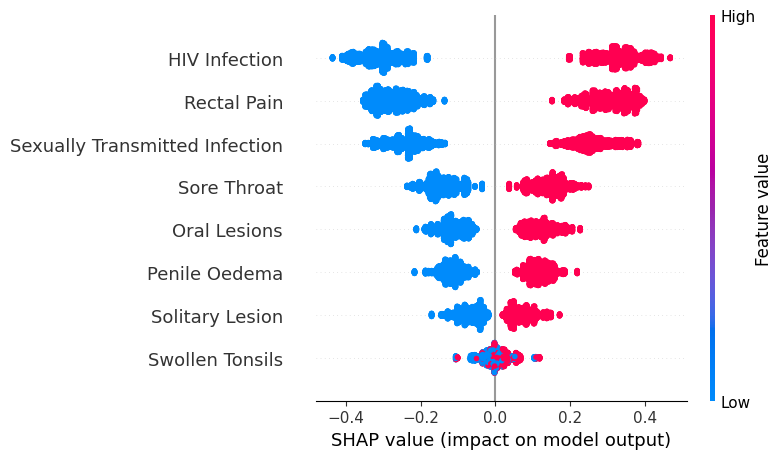

In [85]:
shap_explainer = shap.TreeExplainer(models['Gradient Boosting'])
shap_values = shap_explainer.shap_values(X_test_scaled)

print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test_scaled, feature_names=features)